### Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read csv file

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [3]:
df.shape

(279, 587)

In [4]:
df.iloc[0:5, 0:5]

,Province/State,Country/Region,Lat,Long,1/22/20
0,NaN,Afghanistan,33.93911,67.709953,0
1,NaN,Albania,41.15330,20.168300,0
2,NaN,Algeria,28.03390,1.659600,0
3,NaN,Andorra,42.50630,1.521800,0
4,NaN,Angola,-11.20270,17.873900,0


### Wide to long Dataframe

In [5]:
df_melt=pd.melt(df, id_vars=['Province/State', 'Country/Region', 'Lat', 
                             'Long'], var_name='date', 
                value_name='confirmed_case')
df_melt.head()

,Province/State,Country/Region,Lat,Long,date,confirmed_case
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0


In [6]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162657 entries, 0 to 162656
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Province/State  50721 non-null   object 
 1   Country/Region  162657 non-null  object 
 2   Lat             161491 non-null  float64
 3   Long            161491 non-null  float64
 4   date            162657 non-null  object 
 5   confirmed_case  162657 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 7.4+ MB


In [7]:
df_melt['date']=pd.to_datetime(df_melt.date)

In [8]:
df_melt.head()

,Province/State,Country/Region,Lat,Long,date,confirmed_case
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0
1,NaN,Albania,41.15330,20.168300,2020-01-22,0
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0


In [9]:
df_melt.columns=df_melt.columns.str.replace('/','_')

In [10]:
df_melt.columns

Index(['Province_State', 'Country_Region', 'Lat', 'Long', 'date',
       'confirmed_case'],
      dtype='object')

### Bangladesh

In [11]:
df_bd=df_melt[df_melt.Country_Region=='Bangladesh']
df_bd.shape

(583, 6)

In [12]:
df_bd.head()

,Province_State,Country_Region,Lat,Long,date,confirmed_case
20,NaN,Bangladesh,23.685,90.3563,2020-01-22,0
299,NaN,Bangladesh,23.685,90.3563,2020-01-23,0
578,NaN,Bangladesh,23.685,90.3563,2020-01-24,0
857,NaN,Bangladesh,23.685,90.3563,2020-01-25,0
1136,NaN,Bangladesh,23.685,90.3563,2020-01-26,0


In [13]:
df_bd['daily_case']=df_bd.confirmed_case.diff().fillna(0)

<ipython-input-13-9fde01ad6944>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bd['daily_case']=df_bd.confirmed_case.diff().fillna(0)


In [14]:
df_bd.tail()

,Province_State,Country_Region,Lat,Long,date,confirmed_case,daily_case
161282,NaN,Bangladesh,23.685,90.3563,2021-08-22,1461998,4804.0
161561,NaN,Bangladesh,23.685,90.3563,2021-08-23,1467715,5717.0
161840,NaN,Bangladesh,23.685,90.3563,2021-08-24,1472964,5249.0
162119,NaN,Bangladesh,23.685,90.3563,2021-08-25,1477930,4966.0
162398,NaN,Bangladesh,23.685,90.3563,2021-08-26,1482628,4698.0


In [15]:
df_bd.daily_case.max()

16230.0

Text(0, 0.5, 'Number of Confirmed Cases\n')

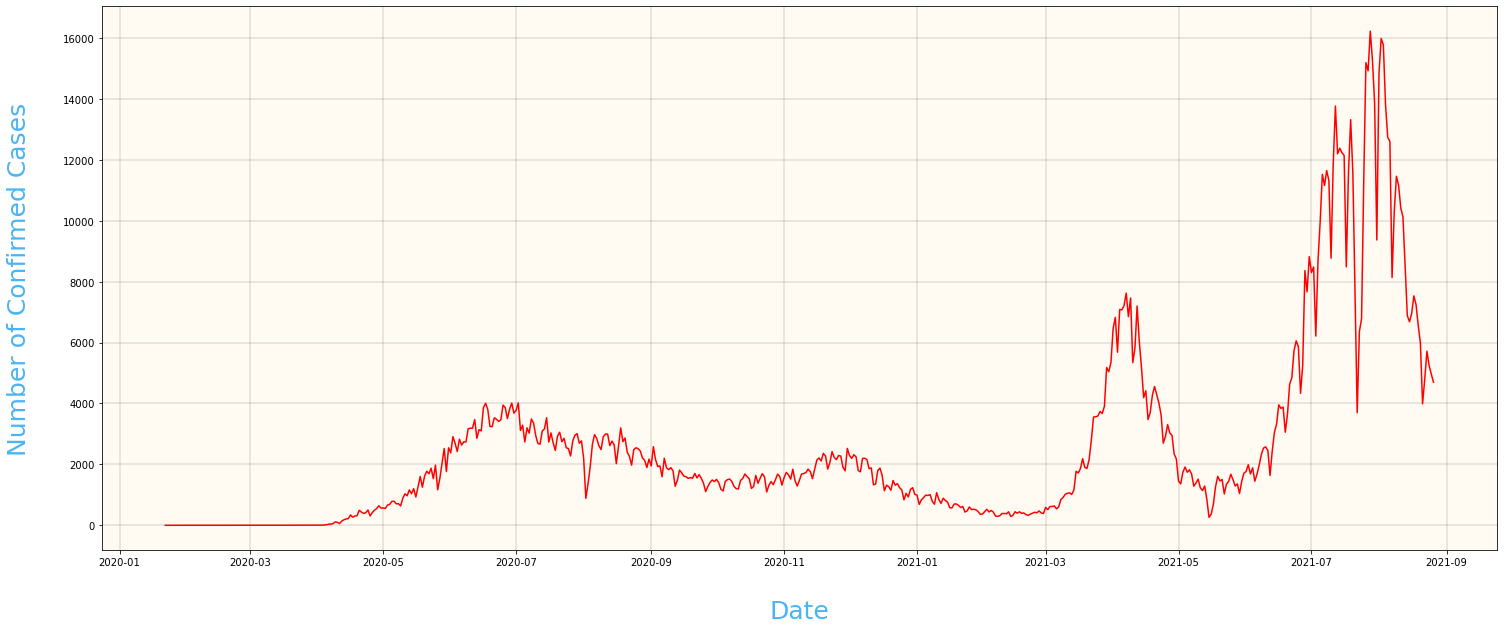

In [16]:
fig, ax=plt.subplots(figsize=(25,10))
ax.grid(linewidth=0.4, color='#8f8f8f') 


ax.plot(df_bd.date,df_bd.daily_case ,color='r', linewidth=1.5)

ax.set_facecolor("#FFFBF3") 
ax.set_xlabel('\nDate',size=25,color='#4bb4f2')
ax.set_ylabel('Number of Confirmed Cases\n',
              size=25,color='#4bb4f2')

In [17]:
bd_monthly=df_bd.groupby([df_bd.date.dt.year,
               df_bd.date.dt.month])['daily_case'].sum()
bd_monthly

date  date
2020  1            0.0
      2            0.0
      3           51.0
      4         7616.0
      5        39486.0
      6        98330.0
      7        92178.0
      8        75335.0
      9        50483.0
      10       44205.0
      11       57248.0
      12       48578.0
2021  1        21629.0
      2        11077.0
      3        65079.0
      4       147837.0
      5        41408.0
      6       112718.0
      7       336226.0
      8       233144.0
Name: daily_case, dtype: float64

In [18]:
bd_2020=bd_monthly[2020]
bd_2020.index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bd_2020

Jan        0.0
Feb        0.0
Mar       51.0
Apr     7616.0
May    39486.0
Jun    98330.0
Jul    92178.0
Aug    75335.0
Sep    50483.0
Oct    44205.0
Nov    57248.0
Dec    48578.0
Name: daily_case, dtype: float64

<BarContainer object of 12 artists>

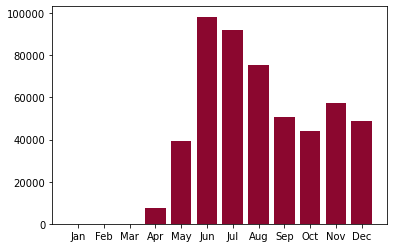

In [19]:
fig, ax=plt.subplots()
#'#003262'
ax.bar(bd_2020.index,bd_2020, color='#8B072F')

In [20]:
bd_2021=bd_monthly[2021]
bd_2021.index=['Jan', 'Feb', 'Mar', 'Apr', "May", "Jun", "Jul", "Aug"]
bd_2021

Jan     21629.0
Feb     11077.0
Mar     65079.0
Apr    147837.0
May     41408.0
Jun    112718.0
Jul    336226.0
Aug    233144.0
Name: daily_case, dtype: float64

<BarContainer object of 8 artists>

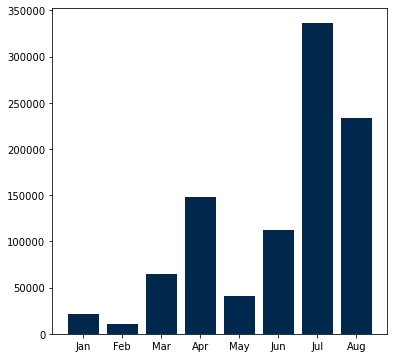

In [21]:
fig, ax=plt.subplots(figsize=(6,6))
ax.bar(bd_2021.index,bd_2021, color='#00274C')

### `resample` method

In [22]:
df_bd.set_index('date', inplace=True)
df_bd.head()

,Province_State,Country_Region,Lat,Long,confirmed_case,daily_case
date,,,,,,
2020-01-22,NaN,Bangladesh,23.685,90.3563,0,0.0
2020-01-23,NaN,Bangladesh,23.685,90.3563,0,0.0
2020-01-24,NaN,Bangladesh,23.685,90.3563,0,0.0
2020-01-25,NaN,Bangladesh,23.685,90.3563,0,0.0
2020-01-26,NaN,Bangladesh,23.685,90.3563,0,0.0


In [23]:
df_bd.daily_case.resample('M').sum()

date
2020-01-31         0.0
2020-02-29         0.0
2020-03-31        51.0
2020-04-30      7616.0
2020-05-31     39486.0
2020-06-30     98330.0
2020-07-31     92178.0
2020-08-31     75335.0
2020-09-30     50483.0
2020-10-31     44205.0
2020-11-30     57248.0
2020-12-31     48578.0
2021-01-31     21629.0
2021-02-28     11077.0
2021-03-31     65079.0
2021-04-30    147837.0
2021-05-31     41408.0
2021-06-30    112718.0
2021-07-31    336226.0
2021-08-31    233144.0
Freq: M, Name: daily_case, dtype: float64

<AxesSubplot:xlabel='date'>

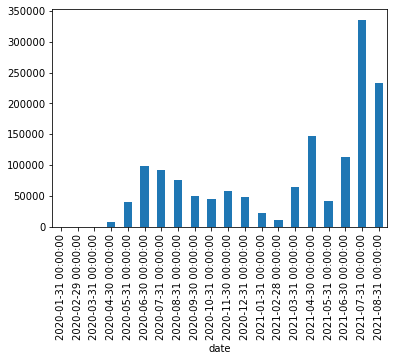

In [24]:
df_bd.daily_case.resample('M').sum().plot(kind='bar')

### Stationarity check

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
adfuller(df_bd.daily_case)

(-2.5005627158492962,
 0.11533746994544303,
 17,
 565,
 {'1%': -3.4419770063102213,
  '5%': -2.866669060591297,
  '10%': -2.5695016312945413},
 8747.54727571626)

In [27]:
result = adfuller(df_bd.daily_case)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.500563
p-value: 0.115337
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570
Failed to Reject Ho - Time Series is Non-Stationary


### bokeh app

In [28]:
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Select, HoverTool, DatetimeTickFormatter
from bokeh.layouts import column
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

In [29]:
output_notebook()

Loading BokehJS ...

In [30]:
def modify_doc(doc):
    raw=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
    raw_melt=pd.melt(raw, id_vars=['Province/State', 'Country/Region', 'Lat', 
                                 'Long'], var_name='date', 
                    value_name='confirmed_case')
    raw_melt["date"]=pd.to_datetime(raw_melt.date)
    df=pd.pivot_table(raw_melt, index="date", columns="Country/Region", 
                      values="confirmed_case",
                      aggfunc='sum')
    df=df.diff().dropna()
    bangladesh=pd.DataFrame(df.Bangladesh).reset_index()
    source=ColumnDataSource(dict(date=bangladesh.date, daily_case=bangladesh.iloc[:,-1]))
    hover=HoverTool(tooltips=[("date", "@date{%F}"), 
                        ("daily case", "@daily_case")], 
    formatters={"@date" : "datetime"}, mode="mouse")
    country_list=df.columns.tolist()

    p=figure(plot_width=600, plot_height=300, x_axis_type="datetime", 
             sizing_mode="stretch_both", 
             tools=[hover, "pan", "reset", "save"])
    p.line(x="date", y="daily_case", source=source, color="DarkBlue", 
          line_width=1.5)
    select=Select(title="Country", options= country_list, 
                  value="Bangladesh", background="orange")
    
    p.xaxis.axis_label="Time"
    p.xaxis.axis_label_text_color="DarkGreen"
    p.xaxis.formatter=DatetimeTickFormatter(months="%b %y")

    p.yaxis.axis_label="Daily infection"
    p.yaxis.axis_label_text_color="DarkGreen"

    p.title.text="Daily Covid case in Bangladesh"
    p.title.text_font="ecotype"
    p.title.text_color="DarkGreen"
    p.title.text_font_size="20px"

    def update_data(attr, old, new):
        desired_country=select.value
        p.title.text=f"Daily Covid case in {desired_country}"
        source_data=pd.DataFrame(df[desired_country]).reset_index()
        source.data=dict(date=source_data.date, daily_case=source_data.iloc[:,-1])

    select.on_change("value", update_data)
    inputs=column(select, p)
    doc.add_root(inputs)
handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app, notebook_url="http://localhost:8888")